One worry: how are we going to keep track of changes as we go across? like temp and stuff. But that would just be a system of PDEs

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
#choses backend pytorch here if it hasnt already

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
a = 0.4
L = 1
n = 1
t_max = 1

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

def boundary_val_l(x):
    return 1 #sets value of T = 1

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0],0) #x[0] is the x axis and after the comma is the position, x[1] is the y-axis if ur working in 2D

def boundary_flux_r(x):
    return 0 #sets dy/dx = 0

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0],L) #because now were at L we need to put L there

def boundary_in(x, on_initial):
    return on_initial and dde.utils.isclose(x[1],0) #i guess here t is x's 2nd index (so 1)

def func_zeros(x):
    return np.zeros((len(x),1))

In [4]:
bc_l = dde.DirichletBC(geomtime, boundary_val_l, boundary_l) #might have to change to dde.icbc. ...
bc_r = dde.NeumannBC(geomtime, boundary_flux_r, boundary_r)
ic = dde.IC(geomtime, func_zeros, boundary_in)

data = dde.data.TimePDE(geomtime, pde, [bc_l, bc_r, ic], num_domain=2540, num_boundary=80, num_initial=160, num_test=2540)
#The number 2540 is the number of training residual points sampled inside the domain, and the number 80 is the number of training points sampled on the boundary. We also include 160 initial residual points for the initial conditions.
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
#up to this point is the last example. Now if we want to make it more accurate we use the following code
model.compile("L-BFGS-B")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)


Compiling model...
'compile' took 1.362535 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.36e-02, 1.19e+00, 2.39e-02, 1.32e-02]    [3.15e-02, 1.19e+00, 2.39e-02, 1.32e-02]    []  
1000      [4.48e-03, 1.84e-02, 5.42e-04, 1.59e-02]    [2.91e-03, 1.84e-02, 5.42e-04, 1.59e-02]    []  


KeyboardInterrupt: 

Text(0.5, 0, 'T')

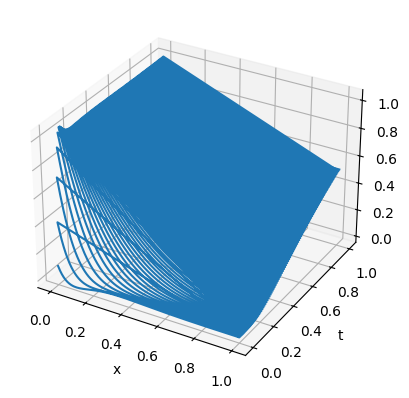

In [ ]:
t = np.linspace(0, t_max, 100)
x = np.linspace(0, L, 200)
xx, tt = np.meshgrid(x, t) #since the two are different lengths we have to make this grid
X = np.vstack((xx.ravel(), tt.ravel())).T #here we are stacking them together. We are basically making a list of points (x, t) 100*200 of them because we can only feed one point to the model

y_pred = (model.predict(X)).reshape(len(t), len(x))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xx, tt, y_pred)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('T')


Text(0, 0.5, 't')

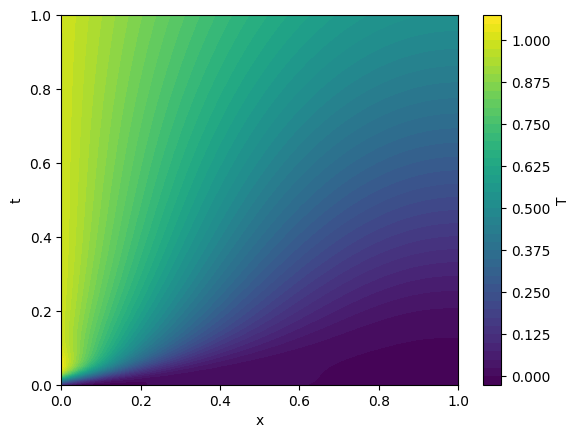

In [ ]:
plt.contourf(xx, tt, y_pred, levels = 50)
plt.colorbar(label='T')
plt.xlabel('x')
plt.ylabel('t')